In [3]:
#import libraries
import numpy as np #for matrix calculations
import pandas as pd #for data analysis and preprocessing
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization

from sklearn import linear_model #linear models
from sklearn import tree #decision trees
from sklearn import ensemble #ensembles
from sklearn import metrics #metrics
from sklearn import preprocessing #preprocessing
from sklearn.model_selection import train_test_split #sample splitting

%matplotlib inline
plt.style.use('seaborn')
from sklearn.model_selection import GridSearchCV # optimization method
from sklearn.model_selection import RandomizedSearchCV # optimization method
from sklearn.model_selection import cross_val_score # k-fold валидация
from sklearn.model_selection import StratifiedKFold # k-fold валидация
import hyperopt # optimization method
from hyperopt import hp, fmin, tpe, Trials
import optuna # optimization method

In [4]:
data_activity = pd.read_csv('data/_train_sem09__1_.zip')

In [5]:
data_activity.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_activity.shape

(3751, 1777)

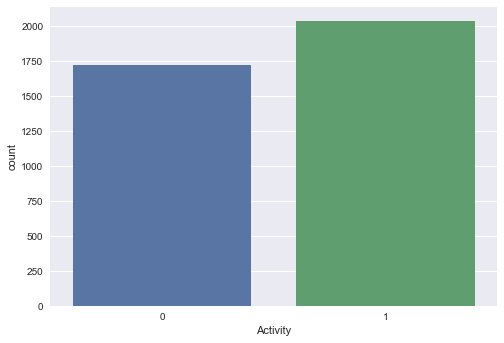

In [7]:
# Looking at the balance of classes:
sns.countplot(data=data_activity, x='Activity');
# # classes are not strong, but not balanced

In [8]:
# Creating a matrix of observations X and a vector of responses y
X = data_activity.drop(['Activity'], axis=1)
y = data_activity['Activity']

In [9]:
# We divide the sample into training and test in the ratio of 80/20. 
# To preserve the ratios of the target attribute, we use the stratify parameter (stratified partitioning).
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [10]:
from locale import normalize


display(y_train.value_counts(normalize = True))
y_test.value_counts(normalize = True)
# The training and test samples are balanced

1    0.542333
0    0.457667
Name: Activity, dtype: float64

1    0.541944
0    0.458056
Name: Activity, dtype: float64

In [11]:
#Creating an object of the logistic regression class
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Training the model by minimizing logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
print("f1_score на train: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на train: 0.89
f1_score on the test set: 0.78


In [12]:
#Creating an object of the random forest class
rf = ensemble.RandomForestClassifier(random_state=42)

#Training the model
rf.fit(X_train, y_train)
#Output metric values
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# It can be seen that the model has signs of retraining, however, a good score was obtained on test

Train: 1.00
Test: 0.80


### <center> **GridSearchCV**

### LogisticRegression

In [13]:
# setting the range of parameters for logistic regression
param_grid = {'penalty': ['l2', 'none'] , # type of regularization
              'solver': ['lbfgs', 'sag'], # optimization algorithm
               'C': [0.01, 0.5, 1]}
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,#random number generator
        max_iter=1000 #number of iterations for convergence
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score on the train set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameter values: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score on the train set: 0.80
f1_score on the test set: 0.78
Best hyperparameter values: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [14]:
y_train_pred = grid_search.predict(X_train)
print(' {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameter values: {}".format(grid_search.best_params_))

 0.82
f1_score on the test set: 0.78
Best hyperparameter values: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


### RandomForestClassifier

In [15]:

# Оптимизируем параметры RandomForestClassifier с кросс-валидацией на пяти фолдах

param_grid = {'n_estimators': [100, 300] , # количество деревьев
              'min_samples_leaf': [5,7], # минимальное количество объектов в листе
               'max_depth': [15,35]}

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42, #генератор случайных чисел
        # max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score on the train set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameter values: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score on the train set: 0.94
f1_score on the test set: 0.80
Best hyperparameter values: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 300}


### <center> **RandomizedSearchCV**

### LogisticRegression

In [16]:
# задаем распределение параметров для поиска по методу RandomizedSearchCV
param_distributions = {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 1]}
            
random_search_logreg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1,
    return_train_score=True
)  
%time 
random_search_logreg.fit(X_train, y_train) 
y_train_pred = random_search_logreg.predict(X_train)
print('f1_score on the train set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_logreg.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(" Best hyperparameter values:{}".format(random_search_logreg.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


f1_score on the train set: 0.82
f1_score on the test set: 0.78
 Best hyperparameter values:{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


### RandomForestClassifier

In [17]:
# задаем распределение параметров для поиска по методу RandomizedSearchCV
param_distributions = {'min_samples_leaf': [3,5,7],
              'max_depth': [15,40],
              'criterion':['entropy','gini'],
              'n_estimators':[100,300]
              }
            
random_search_randomforest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1,
    return_train_score=True
)  


In [18]:
%time 
random_search_randomforest.fit(X_train, y_train) 
y_train_pred = random_search_randomforest.predict(X_train)
print('f1_score on the train set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_randomforest.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameter values: {}".format(random_search_randomforest.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score on the train set: 0.98
f1_score on the test set: 0.81
Best hyperparameter values: {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 40, 'criterion': 'entropy'}


### <center> Hyperopt

In [19]:
#do the import and output the library version
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin is the main function, it will minimize our functionality
# tpe - optimization algorithm
# hp - includes a set of methods for declaring the hyperparameter search space
# trails - used for logging results

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


### LogisticRegression

In [20]:
# setting possible values of logistic regression parameters
list_solver = ['liblinear', 'saga']
list_penalty = ['l2','l1']

search_space = {
                'solver':  hp.choice(label='solver', options=list_solver),
                'penalty' : hp.choice(label='penalty', 
                          options=list_penalty),
                'C' : hp.uniform(label='C', 
                        low=0.01, 
                        high=1)
                }

In [21]:
# fix random_state
random_state = 42
def hyperopt_logreg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # the function gets a combination of hyperparameters in "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': params['C']
              }
   
  
    # use this combination to build a model
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)

    # training the model
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # you can also train the model using cross validation
# apply cross validation with the same number of folds
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # the metric needs to be minimized, so we put a minus sign
    return -score

In [24]:
# starting the selection of hyperparameters
%time

trials = Trials() # used for logging results

best=fmin(hyperopt_logreg,  # our function
          space=search_space, # hyperparameter space
          algo=tpe.suggest, # optimization algorithm, set by default, optional
          max_evals=20, # maximum number of iterations
          trials=trials, # logging of results
          rstate=np.random.default_rng(random_state)  # fix for repeatability of the result
         )
print("Best hyperparameter values {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
 30%|███       | 6/20 [01:53<05:31, 23.65s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 11/20 [04:10<02:47, 18.60s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [07:26<01:51, 27.81s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [10:32<00:00, 31.64s/trial, best loss: -0.7920651360713664]
Best hyperparameter values {'C': 0.16941386753130935, 'penalty': 1, 'solver': 1}


In [25]:
# Log. reg. with the best parameters
model = linear_model.LogisticRegression(
    random_state=random_state, 
    solver=list_solver[best['solver']],
    penalty=list_penalty[best['penalty']],
    C=best['C'], 
    max_iter=1000
    )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.82
f1_score on the test set: 0.78


In [30]:
# let's define the hyperparameter search space
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 50),
       'max_depth' : hp.quniform('max_depth', 15, 21, 2),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 8, 3)
      }

### RandomForestClassifier

In [31]:
# fix random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # the function gets a combination of hyperparameters in "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # use this combination to build a model
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # training the model
    model.fit(X, y)
    
    # you can also train the model using cross validation
# apply cross validation with the same number of folds
   
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # the metric needs to be minimized, so we put a minus sign
    return -score

In [34]:
# starting the selection of hyperparameters
%time

trials = Trials() # used for logging results

best=fmin(hyperopt_rf, # our function
          space=space, # hyperparameter space
          algo=tpe.suggest, # optimization algorithm, set by default, optional
          max_evals=20, # maximum number of iterations
          trials=trials, # logging of results
          rstate=np.random.default_rng(random_state) # fix for repeatability of the result
         )
print("Best hyperparameter values {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [01:21<00:00,  4.07s/trial, best loss: -0.8160314454584471]
Best hyperparameter values {'max_depth': 16.0, 'min_samples_leaf': 3.0, 'n_estimators': 150.0}


In [35]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score on the training set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score in the test set:{:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score on the training set: 0.97
f1_score in the test set:0.80


## <center> Optuna

### LogisticRegression

In [36]:
def optuna_log_reg(trial):
  # defining hyperparameter search spaces
  solver = trial.suggest_categorical('solver', list_solver)
  penalty = trial.suggest_categorical('penalty', list_penalty)
  C = trial.suggest_float('C', 0.01, 1)

  # creating a model
  model = linear_model.LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=random_state, max_iter=1000)
  
  
  # training the model
  model.fit(X_train, y_train)
  
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score

In [37]:
%time
# creating a research object
# we can directly indicate that we need to maximize the metric direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# looking for the best combination of hyperparameters n_trials times
study.optimize(optuna_log_reg, n_trials=20)

[I 2022-10-06 15:33:57,193] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-10-06 15:35:40,189] Trial 0 finished with value: 0.783661995718675 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.7529313707906248}. Best is trial 0 with value: 0.783661995718675.
[I 2022-10-06 15:36:07,893] Trial 1 finished with value: 0.7885666487200088 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.12567899612594033}. Best is trial 1 with value: 0.7885666487200088.
[I 2022-10-06 15:36:08,790] Trial 2 finished with value: 0.7892173046268852 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.2217932943640443}. Best is trial 2 with value: 0.7892173046268852.
[I 2022-10-06 15:36:10,169] Trial 3 finished with value: 0.7866293480171617 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.535336550090106}. Best is trial 2 with value: 0.78

In [38]:
# выводим результаты на обучающей выборке
print("Best hyperparameter values: {}".format(study.best_params))
print("f1_score on the training set: {:.2f}".format(study.best_value))

Best hyperparameter values: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.018420352408761276}
f1_score on the training set: 0.79


In [39]:
# we set the best Optuna parameters for log regression and evaluate score for train and test
model = linear_model.LogisticRegression(
    random_state=random_state, 
    solver=study.best_params['solver'],
    penalty=study.best_params['penalty'],
    C=study.best_params['C']
    )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f'f1_score on the training set: {metrics.f1_score(y_train, y_train_pred)}')
print(f'f1_score on the training set during cross validation:{cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()}')

y_test_pred = model.predict(X_test)
print(f'f1_score on the test set: {metrics.f1_score(y_test, y_test_pred)}')

f1_score on the training set: 0.8309352517985611
f1_score on the training set during cross validation:0.7916424515447698
f1_score on the test set: 0.7829181494661923


### RandomForest

In [40]:
def optuna_rf(trial):
  # defining hyperparameter search spaces
  n_estimators = trial.suggest_int('n_estimators', 100, 310, 50)
  max_depth = trial.suggest_int('max_depth', 15, 46, 15)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 8, 2)

  # creating a model
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # training the model
  model.fit(X_train, y_train)
  
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score

In [41]:
%time
# creating a research object
# we can directly indicate that we need to maximize the metric direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# looking for the best combination of hyperparameters n_trials times
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-06 15:39:08,423] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [100, 310] and step=50, but the range is not divisible by `step`. It will be replaced by [100, 300].
  warnings.warn(
C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [15, 46] and step=15, but the range is not divisible by `step`. It will be replaced by [15, 45].
  warnings.warn(
C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
[I 2022-10-06 15:39:12,108] Trial 0 finished with value: 0.8088376706401439 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8088376706401439.
C:\Users\Arwielao\AppData\Roaming\Py

In [42]:
# output the results on the training sample
print("Best hyperparameter values {}".format(study.best_params))
print("f1_score on the training set: {:.2f}".format(study.best_value))

Best hyperparameter values {'n_estimators': 300, 'max_depth': 15, 'min_samples_leaf': 3}
f1_score on the training set: 0.82


In [43]:
# Creating a model with the best parameters defined by the Optuna method
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_leaf=study.best_params['min_samples_leaf']
    )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f'f1_score on the training set:{metrics.f1_score(y_train, y_train_pred)}')
print(f'f1_score on the training set during cross validation:{cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()}')
y_test_pred = model.predict(X_test)
print(f'f1_score on the test set: {metrics.f1_score(y_test, y_test_pred)}')

f1_score on the training set:0.9653073645769933
f1_score on the training set during cross validation:0.8159834669911783
f1_score on the test set: 0.8009708737864076


### <center> Сonclusions
1. Four optimization methods were used to find optimal values of model parameters: GRIDSEARCHCV, RANDOMIZEDSEARCHCV, HYPEROPT (Tree-Structured Parzen Estimators algorithm) and Optuna.
2. To reduce the optimization time, the ranges and the number of values of categorical parameters were reduced (for example, the method of finding the maximum of the likelihood function in logistic regression)
3. On all types of optimization, higher scores (f1-world) are observed for Random Forest than for logistic regression
4. The classical GridSearchCV method showed the longest operating time even with relatively small ranges of model parameters